In [2]:
#:author: Philipp Steen

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import matplotlib.mlab as mlab
import math

In [206]:
def Plot_RESI(Locations, Sizes, Fill_Color, Edge_Color, Opacity, Show_Labels, Textcolor, Whichside, Labels):
    for count, value in enumerate(Locations):
        if math.isnan(value[0]) or math.isnan(value[1]):
            print("NaN error")
        else:
            draw_circle = plt.Circle((value[0], value[1]), Sizes[count], 
                                 alpha=Opacity, facecolor = Fill_Color, edgecolor = Edge_Color)
            ax.add_artist(draw_circle)
        if Show_Labels==True:
            
            try:
                label_to_display = float(Labels[count])
                label_to_display = str(round(label_to_display, 2))+" nm"
            except:
                label_to_display = Labels[count]
            
            if Whichside=="left":
                ax.text(value[0]-11, value[1]-1, label_to_display, color = Textcolor)
            else:
                ax.text(value[0]+1.5, value[1]-1, label_to_display, color = Textcolor)

def ResiPrec(K, NeNa):
    if K != 0:
        return(NeNa/(math.sqrt(K)))
    else:
        return(10000000000)

def FindCorners(R1_table, R3_table):
    #Find innermost data points to adjust field of view for the plot
    Minx = min(R1_table["x"].min(), R3_table["x"].min())*130 -5
    Miny = max(R1_table["y"].max(), R3_table["y"].max())*130 +5
    
    #Find outermost data points to adjust field of view for the plot
    maxOuter = max(((max(R1_table["x"].max(), R3_table["x"].max())*130)-Minx), 
                   (-(min(R1_table["y"].min(), R3_table["y"].min())*130)+Miny)) +5
    
    return(Minx, Miny, maxOuter)

def Transform(R1_table, R3_table, Minx, Miny, maxOuter):
    #Transform data points from pixels to nanometers and set the bottom left of the plot to 0,0
    R1_table["x"] = 130*R1_table["x"]-Minx
    R3_table["x"] = 130*R3_table["x"]-Minx
    R1_table["y"] = -(130)*R1_table["y"]+Miny
    R3_table["y"] = -(130)*R3_table["y"]+Miny
    return(R1_table, R3_table)

def DistanceFinder(R1_centers, R3_centers, max_distance):
    R1_indices = []
    Distances = []
    All_distances = []
    for count, value in enumerate(R1_centers):
        R1_indices.append(count)
        for j in R3_centers:
            distance = (np.sqrt((value[0]-j[0])**2 + ((value[1]-j[1])**2)))
            if math.isnan(distance) == False:
                All_distances.append(distance)
        if len(All_distances) != 0:
            best_distance = np.min(All_distances)
        else:
            best_distance = 0
        All_distances = []
        if best_distance <= max_distance:
            Distances.append((count, best_distance))
        else:
            Distances.append((count, "-"))
    return(Distances)

In [207]:
#################################
##                             ##
##  Input and format the data  ##
##                             ##
#################################


input_path_R1 = "/clusters-in-r1.hdf5"
input_path_R3 = "/clusters-in-r3.hdf5"

input_path_R1_messy = "/all-in-r1.hdf5"
input_path_R3_messy = "/all-in-r3.hdf5"

NeNa = 3.5


#Read in data
R1_table = pd.read_hdf(input_path_R1, key = 'locs')
R3_table = pd.read_hdf(input_path_R3, key = 'locs')
R1_table.sort_values(by=['group', 'frame'])
R3_table.sort_values(by=['group', 'frame'])

R1_messy = pd.read_hdf(input_path_R1_messy, key = 'locs')
R3_messy = pd.read_hdf(input_path_R3_messy, key = 'locs')

Minx, Miny, maxOuter = FindCorners(R1_table, R3_table)

R1_table, R3_table = Transform(R1_table, R3_table, Minx, Miny, maxOuter)
R1_messy, R3_messy = Transform(R1_messy, R3_messy, Minx, Miny, maxOuter)

In [208]:
R1_RESI = []
R3_RESI = []

R1_prec = []
R3_prec = []

#These pick (group) numbers correspond to R1 and R3 sites
for i in range(max(R1_table["group"].max(), R3_table["group"].max()) + 1):
    R1 = (R1_table[R1_table["group"] == i])
    Avg_R1 = R1["x"].mean(), R1["y"].mean()
    
    R3 = (R3_table[R3_table["group"] == i])
    Avg_R3 = R3["x"].mean(), R3["y"].mean()
    
    if math.isnan(Avg_R1[0]) == False:
        R1_RESI.append(Avg_R1)
        R1_prec.append(ResiPrec(len(R1), NeNa))
    
    if math.isnan(Avg_R3[0]) == False:
        R3_RESI.append(Avg_R3)
        R3_prec.append(ResiPrec(len(R3), NeNa))
    
    
#Turn the lists into numpy arrays for better usability
R1_RESI = np.asarray(R1_RESI)
R3_RESI = np.asarray(R3_RESI)

R1_prec = np.asarray(R1_prec)
R3_prec = np.asarray(R3_prec)

Distances = DistanceFinder(R1_RESI, R3_RESI, 10)


'''
#Calculate distances in x and y as well as the direct distance
Resi_differences = (R1_RESI - R3_RESI)
Resi_distances = (np.sqrt(Resi_differences[:,0]**2 + Resi_differences[:,1]**2))
print("dx and dy: \n", Resi_differences)
print("Distances: \n", Resi_distances)
'''

'\n#Calculate distances in x and y as well as the direct distance\nResi_differences = (R1_RESI - R3_RESI)\nResi_distances = (np.sqrt(Resi_differences[:,0]**2 + Resi_differences[:,1]**2))\nprint("dx and dy: \n", Resi_differences)\nprint("Distances: \n", Resi_distances)\n'

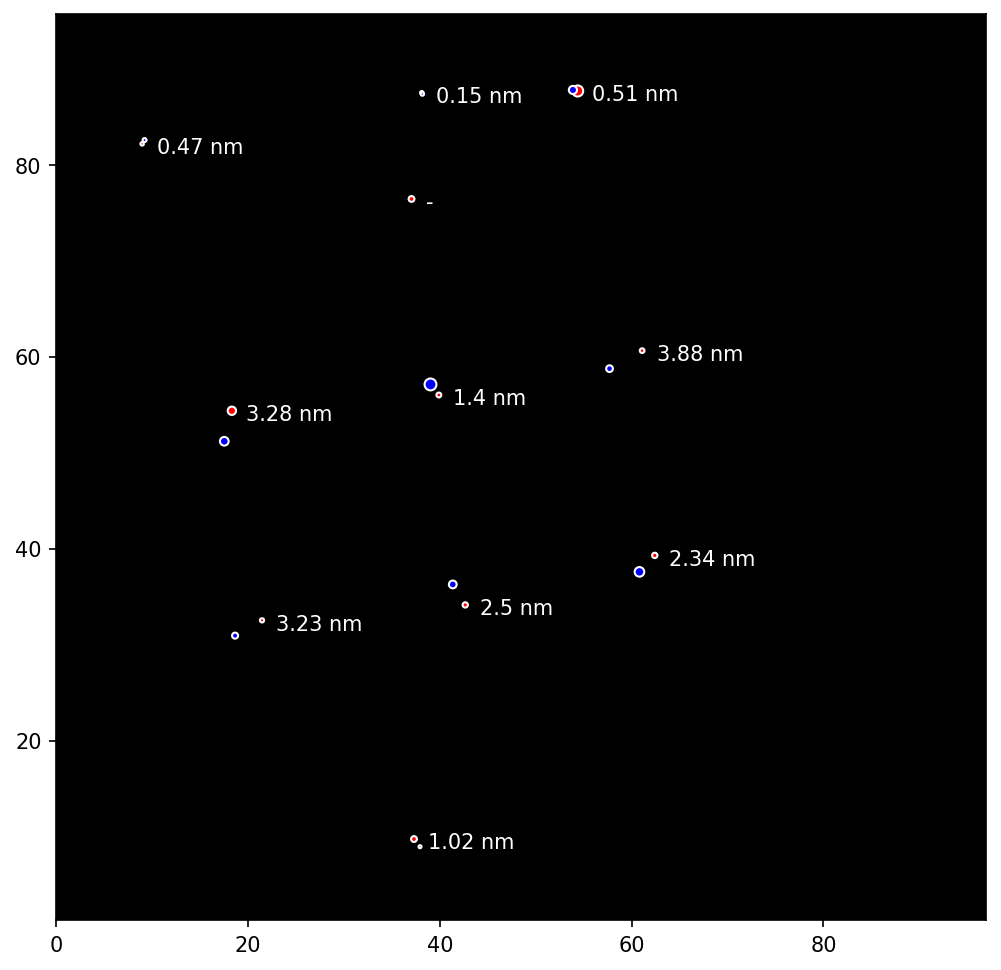

In [211]:
#######################################
##                                   ##
##  Prepare the plot                 ##
##                                   ##
#######################################

color = "black"

size_inches = 8
dpi = 150

fig, ax = plt.subplots(figsize=(size_inches, size_inches), dpi=dpi)

ax.axis('equal')
ax.set_ylim(0, maxOuter)
ax.set_xlim(0, maxOuter)

if color == "black":
    ax.set_facecolor("black")
    alpha1 = 0.4
    alpha2 = 1
    edge = "white"
    textcol = "white"
elif color == "white":
    alpha1 = 0.2
    alpha2 = 0.4
    textcol = "black"
    edge = "black"

Distances = np.asarray(Distances)
labels = Distances[:,1]

#######################################
##                                   ##
##  Plot the original localizations  ##
##                                   ##
#######################################
    
#ax.scatter(R1_table["x"], R1_table["y"], s=0.5, alpha=alpha1, color = "orange")
#ax.scatter(R3_table["x"], R3_table["y"], s=0.5, alpha=alpha1, color = "teal")

#ax.scatter(R1_messy["x"], R1_messy["y"], s=0.4, alpha=alpha1, color = "red")
#ax.scatter(R3_messy["x"], R3_messy["y"], s=0.4, alpha=alpha1, color = "lightblue")

###################################
##                               ##
##  Plot the RESI localizations  ##
##                               ##
###################################

#Plot_RESI(R1_RESI, R1_prec, "red", edge, alpha2, False, textcol, "left", Labels = R1_prec)
Plot_RESI(R1_RESI, R1_prec, "red", edge, alpha2, True, textcol, "right", Labels = labels)
Plot_RESI(R3_RESI, R3_prec, "blue", edge, alpha2, False, textcol, "right", Labels = R3_prec)

